# Explore here

Paso 1: Cargamos los datos y previsualizamos


In [21]:
import pandas as pd

url = 'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'

# Nombramos DataFrame
df = pd.read_csv(url)

# Verificamos columnas
print(df.columns)

# Verificamos que todo esté correcto
print(df.head())
print(df.index)



Index(['date', 'sales'], dtype='object')
                         date      sales
0  2022-09-03 17:10:08.079328  55.292157
1  2022-09-04 17:10:08.079328  53.803211
2  2022-09-05 17:10:08.079328  58.141693
3  2022-09-06 17:10:08.079328  64.530899
4  2022-09-07 17:10:08.079328  66.013633
RangeIndex(start=0, stop=366, step=1)


In [22]:
# Ver los nombres reales de las columnas
print(df.columns)


Index(['date', 'sales'], dtype='object')


Paso 2: Construccion y analisis de la serie temporal

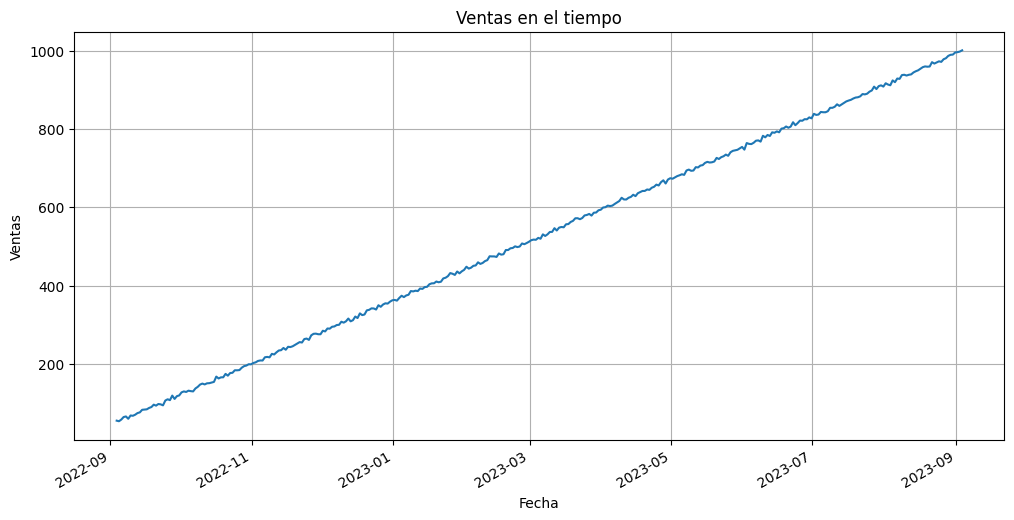

In [23]:
import matplotlib.pyplot as plt

# Convertir la columna de fecha al tipo datetime y establecerla como índice
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Ordenamos
df.sort_index(inplace=True)

# Graficar la serie temporal
df['sales'].plot(figsize=(12, 6), title='Ventas en el tiempo')
plt.ylabel('Ventas')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()


Vemos que las ventas tienen una pendiente positiva, claramente ascendente lo que significa que las ventas no hacen mas que aumentar.

¿Cuál es el tensor de la serie temporal?
¿Cuál es la tendencia?
¿Es estacionaria?
¿Existe variabilidad o presencia de ruido?

In [24]:
# Revisamos frecuencia de datos
print(df.index.to_series().diff().value_counts())


date
1 days    365
Name: count, dtype: int64


Confirmamos que el tensor es diario y no mensual.

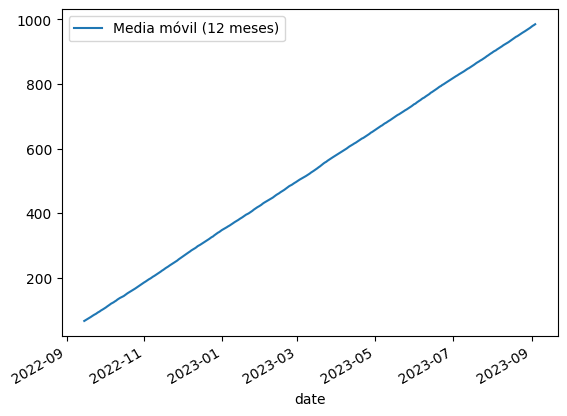

In [ ]:
# Tendencia sacamos media movil
df['sales'].rolling(12).mean().plot(label='Media móvil (12 meses)')
plt.legend()

# Realmente con el primer grafico la tendencia es clara


Realizamos ADF para saber si es estacionaria, aunque no parece que lo sea ya que parece constante en el tiempo

In [27]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: 0.545414193706378
p-value: 0.9861899815311064


Efectivamente confirmamos que no es estacionaria puesto que p>0.05

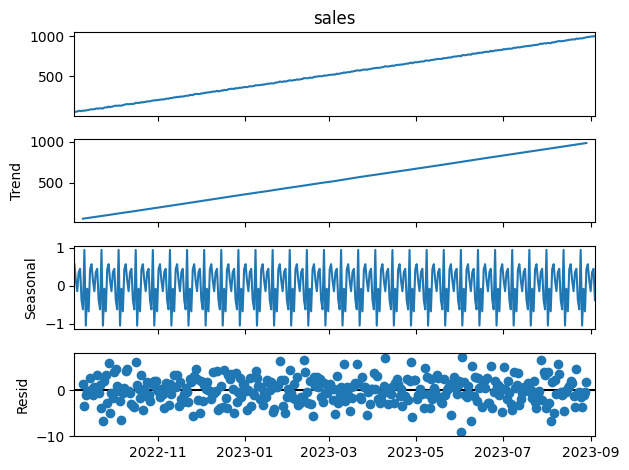

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['sales'], model='additive', period=12)
decomposition.plot()
plt.show()


✅ Tendencia (Trend)
Claramente creciente: La componente de tendencia muestra un crecimiento casi lineal constante.

Esto confirma que las ventas aumentan de forma continua a lo largo del tiempo.

🔁 Estacionalidad (Seasonal)
Se observa una fuerte estacionalidad diaria (como un patrón que se repite cada 7 días aproximadamente).

Esto sugiere ciclos semanales en el comportamiento de ventas (posiblemente más ventas en ciertos días de la semana).

📉 Residuo (Resid)
Los residuos (ruido) parecen estar centrados en 0 y distribuidos aleatoriamente.

Esto indica que el modelo aditivo ha captado bien la tendencia y la estacionalidad, dejando residuos principalmente aleatorios (buen síntoma).

Paso 3: Entrenamiento Arima


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


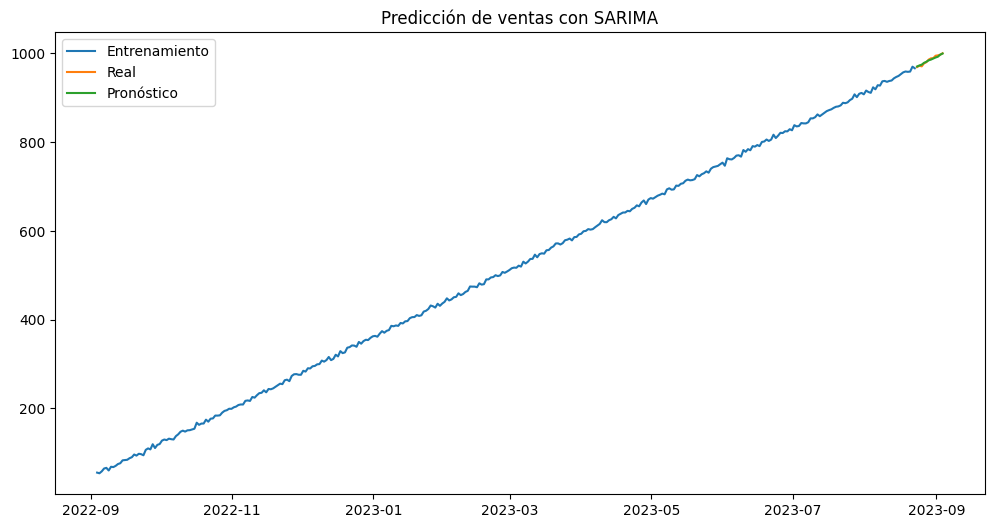

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Separar datos en entrenamiento y prueba
train = df.iloc[:-12]
test = df.iloc[-12:]

# Entrenar modelo SARIMA manualmente (ejemplo con orden ARIMA y estacionalidad)
model = SARIMAX(train['sales'], order=(2,1,2), seasonal_order=(1,1,1,7))
results = model.fit()

# Predicciones
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Comparación visual
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train.index, train['sales'], label='Entrenamiento')
plt.plot(test.index, test['sales'], label='Real')
plt.plot(test.index, forecast, label='Pronóstico')
plt.legend()
plt.title('Predicción de ventas con SARIMA')
plt.show()


Paso 4: Prediccion con test

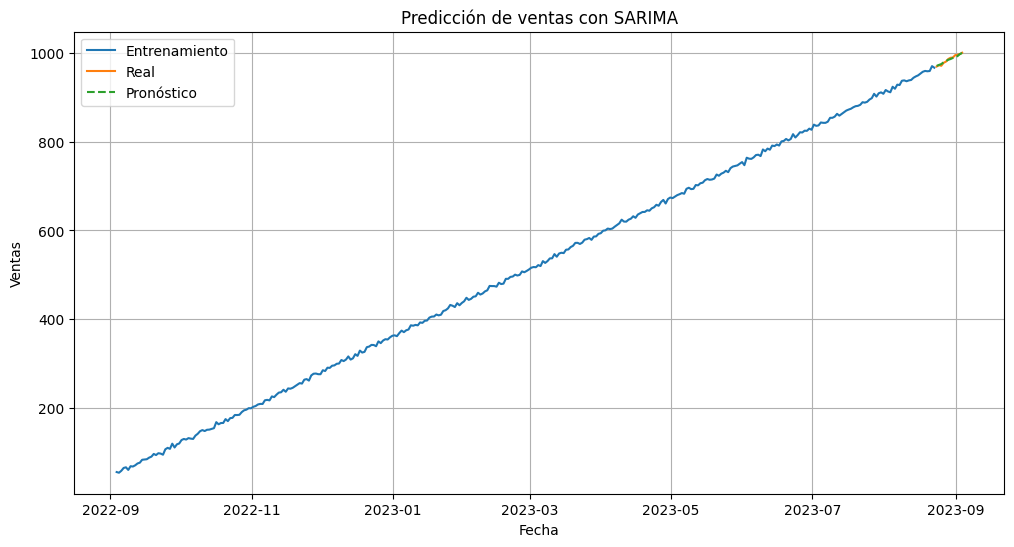

In [33]:
# Predicción
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Convertir a DataFrame para comparaciones si quieres
predicted = pd.DataFrame({
    'real': test['sales'],
    'forecast': forecast
})

plt.figure(figsize=(12,6))
plt.plot(train.index, train['sales'], label='Entrenamiento')
plt.plot(test.index, test['sales'], label='Real')
plt.plot(test.index, forecast, label='Pronóstico', linestyle='--')
plt.title('Predicción de ventas con SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

Evaluamos modelo

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['sales'], forecast)
mse = mean_squared_error(test['sales'], forecast)
rmse = np.sqrt(mse)

print(f"📈 MAE  (Error absoluto medio): {mae:.2f}")
print(f"📉 MSE  (Error cuadrático medio): {mse:.2f}")
print(f"📐 RMSE (Raíz del MSE): {rmse:.2f}")


📈 MAE  (Error absoluto medio): 1.75
📉 MSE  (Error cuadrático medio): 4.73
📐 RMSE (Raíz del MSE): 2.18


| Métrica  | Valor | Interpretación                                                          |
| -------- | ----- | ----------------------------------------------------------------------- |
| **MAE**  | 1.75  | En promedio, el modelo se equivoca por 1.75 unidades de ventas por día. |
| **MSE**  | 4.73  | El error cuadrático medio es bajo, lo que indica buena precisión.       |
| **RMSE** | 2.18  | Los errores grandes están bien controlados (penalización leve).         |


In [37]:
import joblib

# Crear carpeta si no existe
import os
os.makedirs('model', exist_ok=True)

# Guardar el modelo
joblib.dump(results, 'model/sarima_model.pkl')
print("✅ Modelo guardado en: model/sarima_model.pkl")


✅ Modelo guardado en: model/sarima_model.pkl
